In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## Neural Style Transfer and Transfer Learning
Neural Style Transfer (NST) is an interesting optimization technique in deep learning. It merges to images: a **"content" image (C)** and a **"style" image (S)**, to create a **"generated" image (G)**.

NST uses a previously trained convolutional network, and builds on top of that. This is called transfer learning. In this project, I will be using the VGG network from the original NST paper. Specifically, I will be using the VGG-19 network, a 19-layer version of the network. This model has been trained on the ImageNet dataset.

In [2]:
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='D:/Documents/Courses/Projects/Neural Style Transfer/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

# freezing the network
vgg.trainable = False
pp.pprint(vgg)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0     

## The cost function:
There are 2 components to the NST cost function:
- Content cost function: $J_{content}(C, G)$
- Style cost function: $J_{style}(S, G)$
- Finally, these two are combined: $J(G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)$

### Content cost function:
In the shallower layers of a CNN, the model learns low level features whereas in the deeper layers, the model learns complex features. Hence, in the generated image, the content should match that of the input content image. This can be achieved by taking activations from the middle of the CNN.

This cost can be computed by comparing the activations of the style image and the generated image.

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

Content Image (C): 


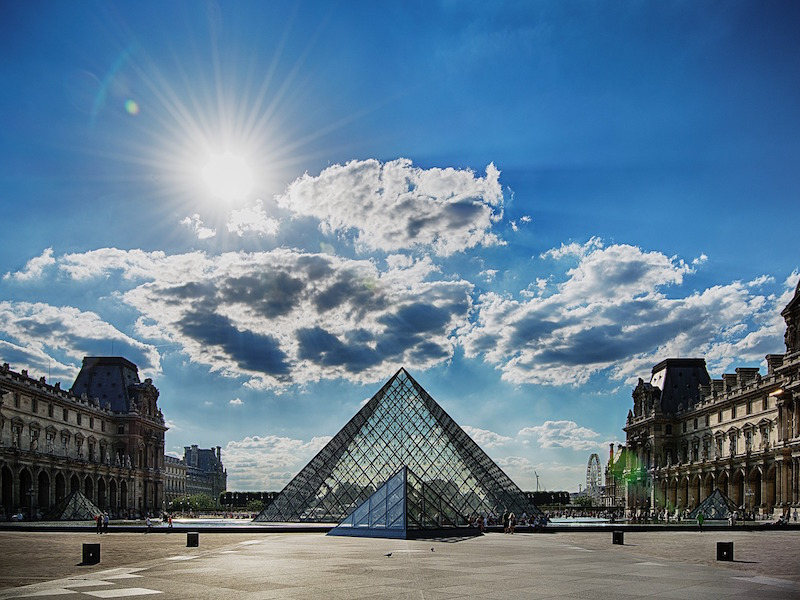

In [3]:
content_image = Image.open('images/louvre.jpg')
print('Content Image (C): ')
content_image

In [4]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape()

    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])

    J_content = tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled, a_G_unrolled)), axis=None)/(4 * n_W * n_C * n_H)

    return J_content

### Style cost function:
- Gram matrix:
    - Matrix elements are calculated by performing a dot product. If two values are similar, dot product is high, else low.
    - $$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$
- For calculating the style cost, we need to see how similar the styles of the style image and the generated images are.
- The gram matrix will help us since it is a correlation matrix.

The cost function for a layer is:
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2$$

Style transfer is better when there is style information from various layers in the CNN. To do this, we calculate the style cost for multiple layers, each weighted with a parameter $\lambda$

Therefore, the final cost function is:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [5]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [6]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape()

    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)), axis=None)/((2 * n_W * n_H * n_C) ** 2)

    return J_style_layer

In [7]:
for layer in vgg.layers:
    print(layer.name)

vgg.get_layer('block5_conv4').output

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


<tf.Tensor 'block5_conv4/Identity:0' shape=(None, 25, 25, 512) dtype=float32>

In [8]:
# choosing layers to represent style of the image:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

### Total cost function
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [10]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    return alpha * J_content + beta * J_style

## Solving the optimization problem:
1. Load the content image
2. Load the style image
3. Randomly initialize the image to be generated
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

(1, 400, 400, 3)


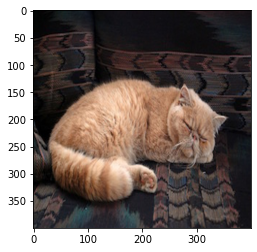

In [48]:
# Loading the content image:
content_image = np.array(Image.open('images/persian_cat_content.jpg').resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


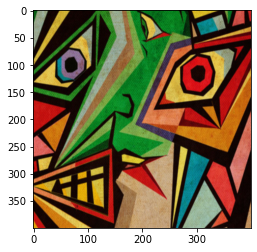

In [32]:
# Loading the style image:
style_image = np.array(Image.open('images/my_style.jpg').resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


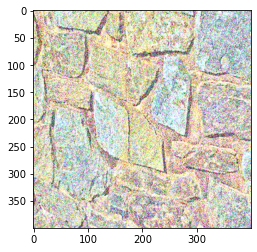

In [33]:
# Randomly initializing image to be generated
# Generated image is slightly correlated with the content image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [34]:
# Getting outputs from pre-trained VGG19 model:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)

    return model

In [42]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [43]:
# getting content and style targets from the model
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [44]:
# computing total cost

# Assign the content image to be the input of the VGG model.
# Setting a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [45]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [46]:
# Training the model:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
         a_G = vgg_model_outputs(generated_image)
         J_style = compute_style_cost(a_S, a_G)
         J_content = compute_content_cost(a_C, a_G)
         J = total_cost(J_content, J_style, alpha=20, beta=40)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Epoch 0 


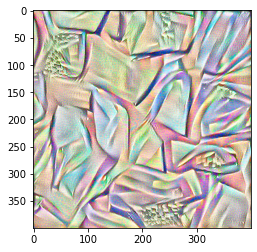

Epoch 250 


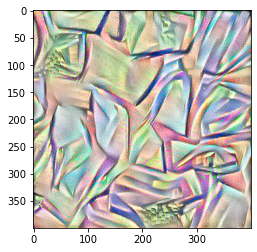

Epoch 500 


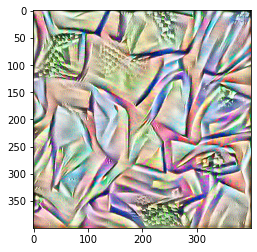

Epoch 750 


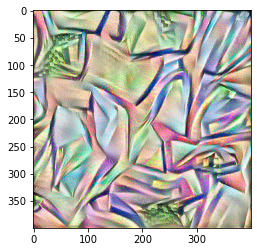

Epoch 1000 


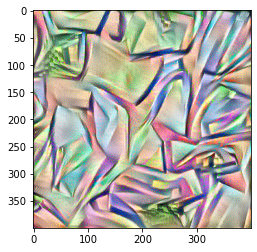

Epoch 1250 


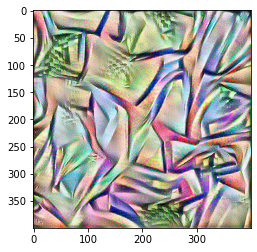

Epoch 1500 


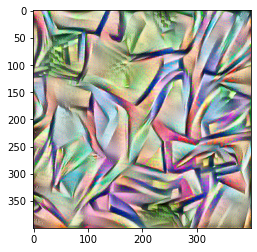

Epoch 1750 


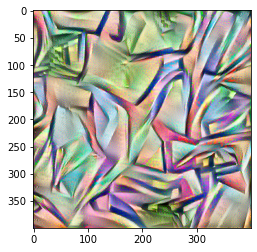

Epoch 2000 


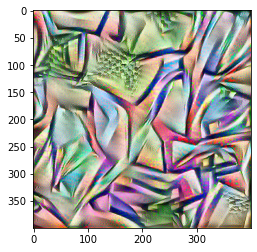

Epoch 2250 


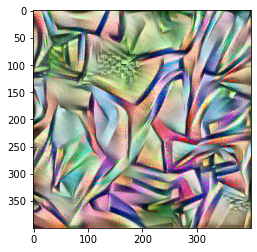

Epoch 2500 


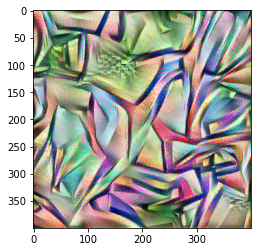

In [47]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"D:/Documents/Courses/Projects/Neural Style Transfer/output/image_{i}.jpg")
        plt.show()